# Understanding Climate Change Discourse on Reddit: A Distributed Analysis of Public Themes, Sentiment, and Recommendations

### Candidate numbers: 39884, 48099, 49308, 50250

## Notebook Overview: Topic and Sentiment Analysis
This notebook analyzes the complete dataset containing predicted topics and sentiment labels. It explores sentiment distribution across topics, computes average sentiment per topic, and visualizes sentiment trends over time.

## Cluster Setup and Initialization Actions
We used Google Cloud Dataproc to create a scalable cluster with the following settings:

#### Create the bucket
```gsutil mb gs://st446-gp-sm```

#### Upload the initialization script
```gsutil cp my_actions.sh gs://st446-gp-sm```

#### Create the Dataproc cluster
```gcloud dataproc clusters create st446-cluster-project \
  --enable-component-gateway \
  --public-ip-address \
  --region europe-west1 \
  --master-machine-type n2-standard-4 \
  --master-boot-disk-size 100 \
  --num-workers 3 \
  --worker-machine-type n2-standard-4 \
  --worker-boot-disk-size 300 \
  --image-version 2.2-debian12 \
  --optional-components=JUPYTER \
  --metadata 'PIP_PACKAGES=sklearn nltk pandas numpy' \
  --initialization-actions='gs://st446-gp-sm/my_actions.sh' \
  --properties=spark:spark.dynamicAllocation.enabled=true \
--project=capstone-data-1-wto

In [1]:
# Import libraries used in this notebook
import zipfile
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import os
from pyspark.sql.functions import when
import re
import seaborn as sns
from pyspark.sql.functions import explode
import matplotlib.pyplot as plt
import hashlib
from datetime import datetime
import numpy as np
import pandas as pd
import string
from pyspark.sql.functions import to_date
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from pyspark.sql import SparkSession
import pyspark.sql.functions as sql_f 
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.clustering import LDA
from time import time
from pyspark.sql.functions import udf, col, rand, monotonically_increasing_id
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, ArrayType
from pyspark.ml.feature import StopWordsRemover, Tokenizer, CountVectorizer, IDF
from pyspark.sql.functions import lower, regexp_replace, row_number, desc
import random
from pyspark.sql.functions import rand
from pyspark.sql.functions import year
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression

# Data Frame Loading after all Predictions

In [2]:
# Define the same path
input_path = "gs://st446-gp-sm/processed_data/df_tf_after_sentiments"

# Load the Parquet data
df = spark.read.parquet(input_path)

# Optional: Check schema or a few rows
df.printSchema()
df.show(5)

root
 |-- type: string (nullable = true)
 |-- id: string (nullable = true)
 |-- subreddit.id: string (nullable = true)
 |-- subreddit.name: string (nullable = true)
 |-- subreddit.nsfw: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- body: string (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- score: integer (nullable = true)
 |-- body_clean: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- filtered: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- final_tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- rawFeatures: vector (nullable = true)
 |-- topicDistribution: vector (nullable = true)
 |-- predictedTopic: integer (nullable = true)
 |-- docTopWords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- PredictedTopicName: string (nullable = true)
 |-- s

+-------+-------+------------+-------------------+--------------+-----------+--------------------+--------------------+---------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+--------------------+---------------+---------------+--------------------+--------------------+-------------------+-------------------------+
|   type|     id|subreddit.id|     subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|sentiment|score|          body_clean|              tokens|            filtered|        final_tokens|         rawFeatures|   topicDistribution|predictedTopic|         docTopWords|  PredictedTopicName|sentiment_class|sentiment_label|       rawPrediction|         probability|PredictionSentiment|predicted_sentiment_label|
+-------+-------+------------+-------------------+--------------+-----------+--------------------+--------------------+---

# Analysis

## Sentiment Distibution per Topic

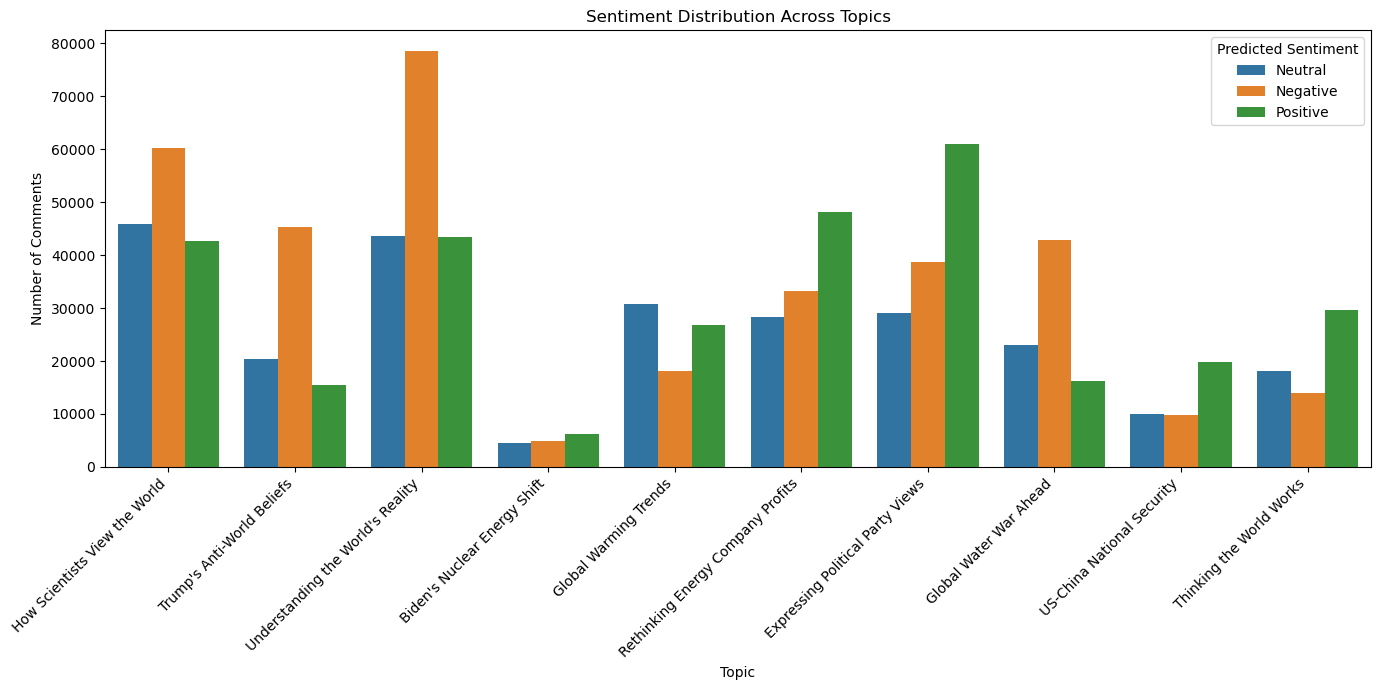

In [3]:
# Group by PredictedTopicName and sentiment
sentiment_counts = df.groupBy("PredictedTopicName", "predicted_sentiment_label").count()
sentiment_pdf = sentiment_counts.toPandas()

# Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=sentiment_pdf, x="PredictedTopicName", y="count", hue="predicted_sentiment_label")
plt.title("Sentiment Distribution Across Topics")
plt.xlabel("Topic")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45, ha='right') 
plt.legend(title="Predicted Sentiment")
plt.tight_layout()
plt.show()

This grouped bar chart shows how sentiment varies across different discussion topics based on the number of Reddit comments labeled as **Positive**, **Neutral**, or **Negative**.

- **Understanding the World's Reality** and **How Scientists View the World** have the **highest overall engagement**, with a large number of comments across all sentiment classes. Notably, **negative sentiment dominates** both topics, suggesting these may be areas of controversy or disagreement.

- **Trump’s Anti-World Beliefs** shows a strong skew toward negative sentiment, with negative comments more than double the positive. This indicates significant disapproval in discussions around this topic.

- **Expressing Political Party Views** is one of the few topics where positive sentiment dominates, suggesting affirmation, support, or pride in one's political alignment.

- **US-China National Security** and **Thinking the World Works** show relatively lower total volume but lean more positively.

- **Global Water War Ahead** is heavily skewed negative, consistent with concern-driven discourse on climate-related issues.

Therefore Reddit users are generally more likely to post when they disagree about a topic. This trend is visible in topics with higher negative comment volumes, reinforcing the idea that negativity is often more vocal online.

## Average Sentiment Score per Topic

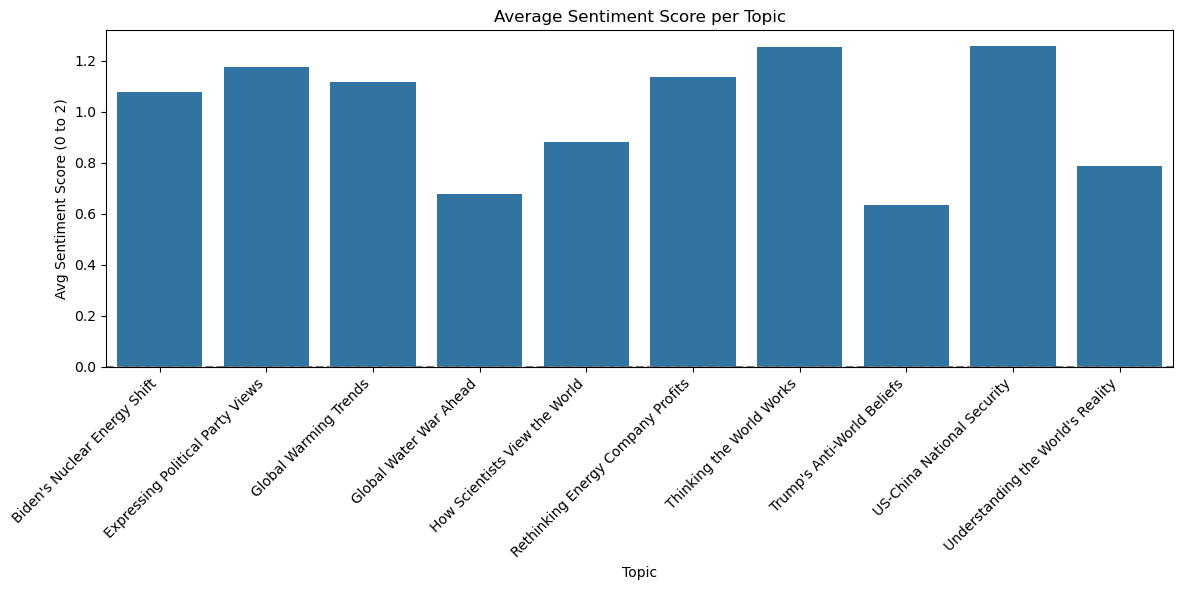

In [22]:
# Group by topic name
avg_sentiment = df.groupBy("PredictedTopicName").avg("PredictionSentiment").orderBy("PredictedTopicName")
avg_sentiment_pdf = avg_sentiment.toPandas()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=avg_sentiment_pdf, x="PredictedTopicName", y="avg(PredictionSentiment)")
plt.title("Average Sentiment Score per Topic")
plt.xlabel("Topic")
plt.ylabel("Avg Sentiment Score (0 to 2)")
plt.axhline(0, color='gray', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Interpretation of Average Sentiment by Topic
This chart visualizes how the overall tone of discussion varies across topics on Reddit. Some key insights:

This chart shows the average sentiment across Reddit comments for each identified topic. Some key takeaways:

- **Neutral-to-Positive Leaning Overall**: Most topics have average sentiment between 1.0 and 1.25, indicating a neutral-to-slightly positive tone in discussions.

- **Most Positive Topics**:
  - **US-China National Security** and **Thinking the World Works** have the highest average sentiment scores. Despite a serious subject matter, the tone appears optimistic. This may be due to sarcasm or humorous takes in community discussions.
  - **Expressing Political Party Views** also scores high, possibly because users are affirming their own political beliefs more than criticizing opposing views.

- **Most Negative Topics**:
  - **Trump’s Anti-World Beliefs** and **Global Water War Ahead** show the lowest sentiment scores, reflecting a higher volume of disagreement, pessimism, or concern.
  
- **Balanced or Mixed Sentiment Topics**:
  - **Global Warming Trends**, **Rethinking Energy Company Profits**, and **Biden’s Nuclear Energy Shift** fall closer to neutral, suggesting a more nuanced or divided discourse.

## Sentiment Trend Over Time per Topic

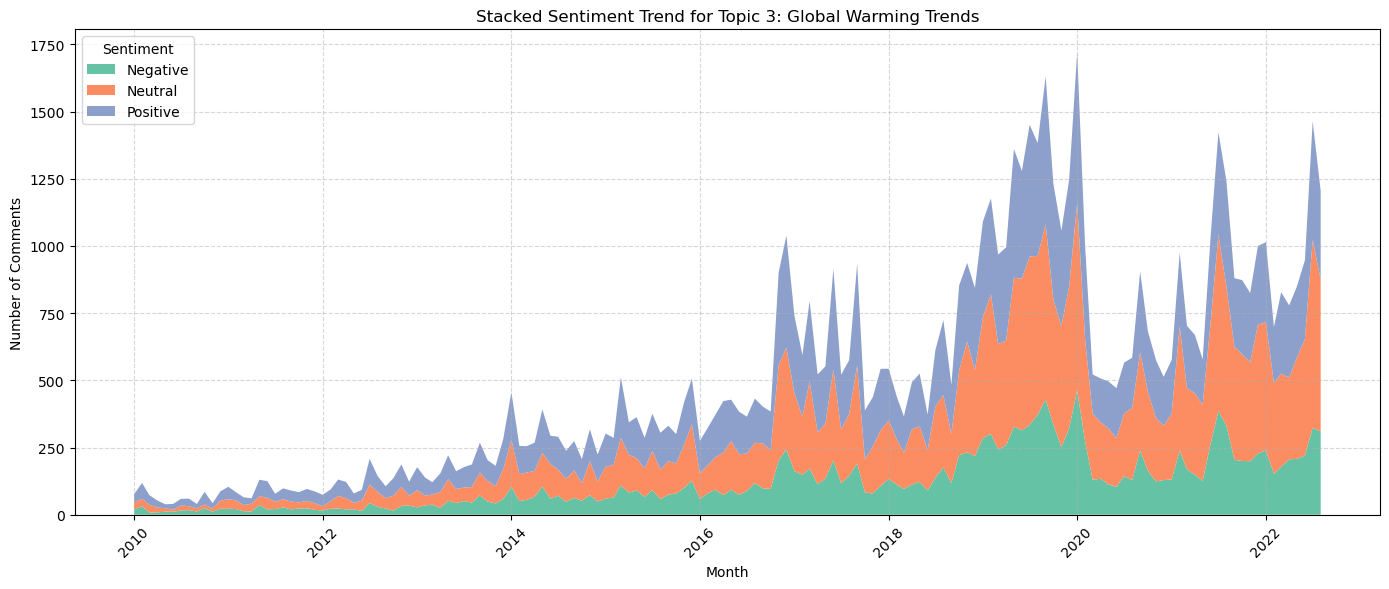

In [18]:
# Prepare 'date' column from 'created_utc'
df = df.withColumn("date", to_date(from_unixtime(col("created_utc").cast("long"))))

# Set the topic number
topic_id = 3 
filtered_df = df.filter(col("predictedTopic") == topic_id)
topic_df = (
    filtered_df
    .select("date", "predicted_sentiment_label")
    .toPandas()
)

# Convert date to month
topic_df["month"] = pd.to_datetime(topic_df["date"]).dt.to_period("M").dt.to_timestamp()
topic_df["count"] = 1

# for stackplot
pivot_df = (
    topic_df.groupby(["month", "predicted_sentiment_label"])["count"]
    .sum()
    .unstack(fill_value=0)
    .sort_index()
)

# topic label 
topic_label_map = (
    df.select("predictedTopic", "PredictedTopicName")
      .dropna()
      .dropDuplicates(["predictedTopic"])
      .toPandas()
      .set_index("predictedTopic")["PredictedTopicName"]
      .to_dict()
)
topic_name = topic_label_map.get(topic_id, f"Topic {topic_id}")

plt.figure(figsize=(14, 6))
plt.stackplot(
    pivot_df.index,
    pivot_df.get("Negative", 0),
    pivot_df.get("Neutral", 0),
    pivot_df.get("Positive", 0),
    labels=["Negative", "Neutral", "Positive"],
    colors=sns.color_palette("Set2", 3)
)
plt.title(f"Stacked Sentiment Trend for Topic {topic_id}: {topic_name}")
plt.xlabel("Month")
plt.ylabel("Number of Comments")
plt.legend(loc="upper left", title="Sentiment")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()


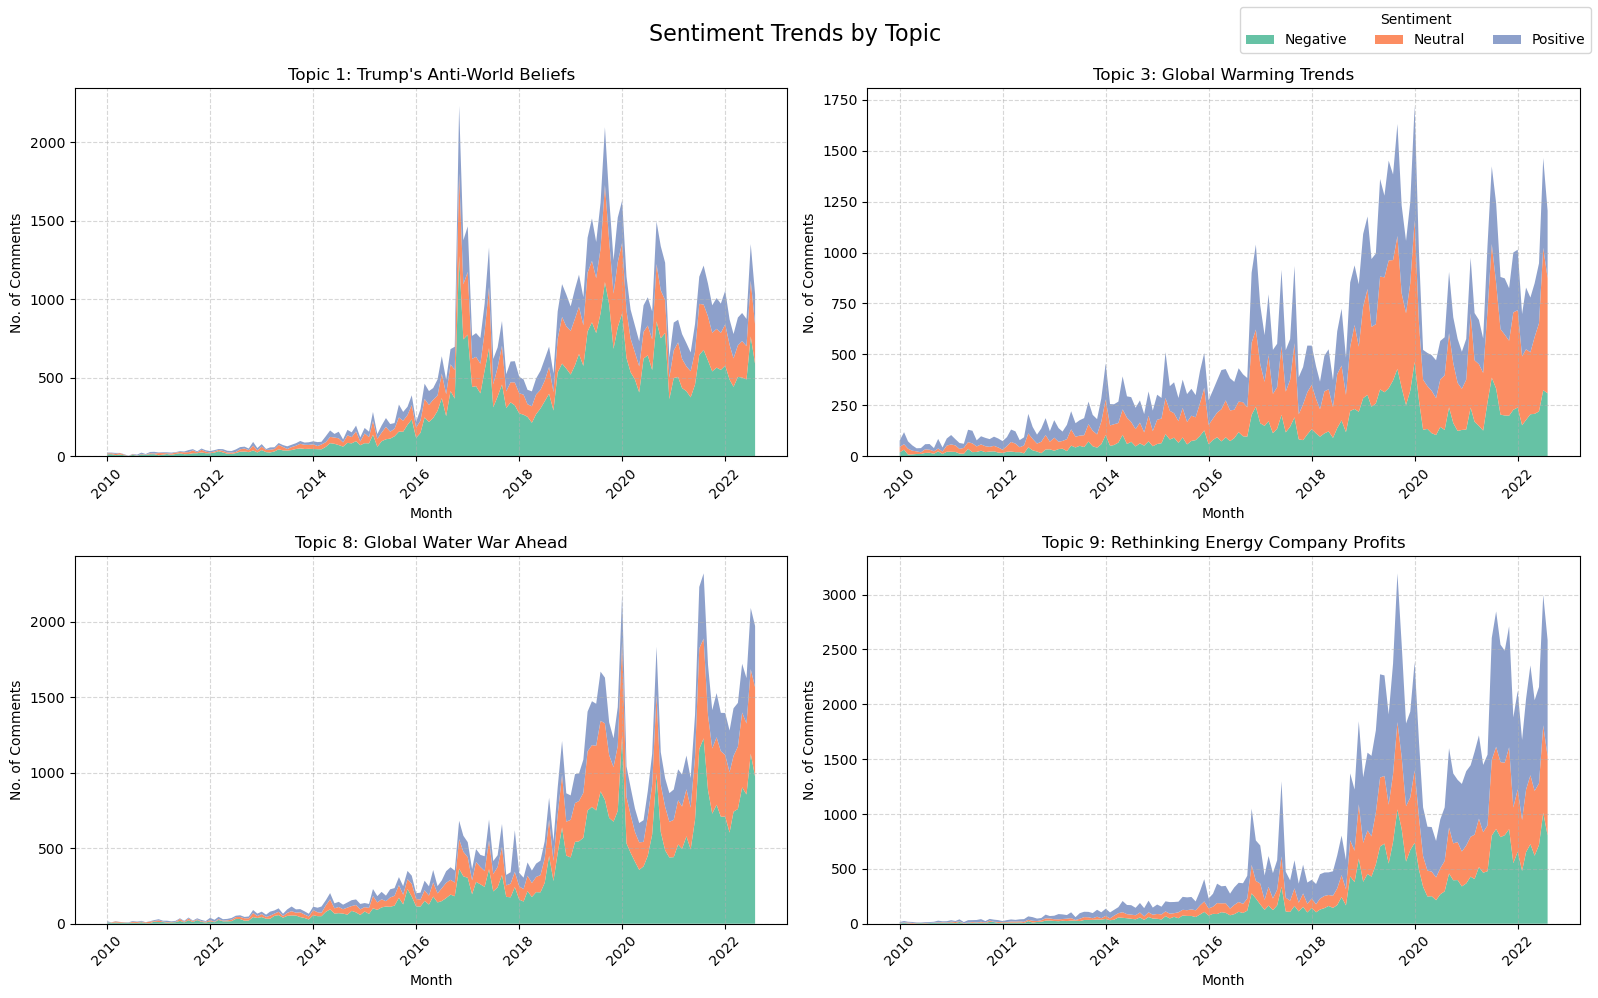

In [21]:
# Prepare 'date' column from 'created_utc'
df = df.withColumn("date", to_date(from_unixtime(col("created_utc").cast("long"))))

# topic label map for lookup
topic_label_map = (
    df.select("predictedTopic", "PredictedTopicName")
      .dropna()
      .dropDuplicates(["predictedTopic"])
      .toPandas()
      .set_index("predictedTopic")["PredictedTopicName"]
      .to_dict()
)

# 2 by 2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()  

# List of topic IDs to plot
topic_ids = [1, 3, 8, 9]

for i, topic_id in enumerate(topic_ids):
    topic_name = topic_label_map.get(topic_id, f"Topic {topic_id}")
    
    # Filter and prepare data
    topic_df = (
        df.filter(col("predictedTopic") == topic_id)
          .select("date", "predicted_sentiment_label")
          .toPandas()
    )
    topic_df["month"] = pd.to_datetime(topic_df["date"]).dt.to_period("M").dt.to_timestamp()
    topic_df["count"] = 1
    
    pivot_df = (
        topic_df.groupby(["month", "predicted_sentiment_label"])["count"]
        .sum()
        .unstack(fill_value=0)
        .sort_index()
    )
    
    ax = axes[i]
    ax.stackplot(
        pivot_df.index,
        pivot_df.get("Negative", 0),
        pivot_df.get("Neutral", 0),
        pivot_df.get("Positive", 0),
        labels=["Negative", "Neutral", "Positive"],
        colors=sns.color_palette("Set2", 3)
    )
    ax.set_title(f"Topic {topic_id}: {topic_name}", fontsize=12)
    ax.set_xlabel("Month")
    ax.set_ylabel("No. of Comments")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='x', rotation=45)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=3, title="Sentiment")
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.suptitle("Sentiment Trends by Topic", fontsize=16)
plt.show()


### Interpretation of Stacked Sentiment Area Charts
The stacked area plots show how Reddit sentiment has evolved over time across four key topics. Some key observations:

- Consistent Volume Growth: All topics show a clear rise in engagement (comment volume) starting around 2016–2017, likely reflecting increased public discourse and data availability.

- Topic 1 – Trump’s Anti-World Beliefs: Peaks around 2016 and 2020 align with U.S. presidential election cycles, showing a high volume of negative sentiment, especially during Trump’s presidency.

- Topic 3 – Global Warming Trends: Displays a more balanced sentiment mix, but still skewed negative. Discussion intensifies post-2016, reflecting growing climate awareness.

- Topic 8 – Global Water War Ahead: Steady rise with mostly negative and neutral sentiment, likely due to the severity of water scarcity discussions.

- Topic 9 – Rethinking Energy Company Profits: A clear increase in positive sentiment in recent years, suggesting shifts in perception around clean energy or corporate accountability.

- Prevalence of Negative Sentiment: Across most topics, negative sentiment tends to dominate. This reflects an observed tendency in online platforms where users are more likely to speak out when they disagree, are alarmed, or feel strongly opposed — negative opinions often drive stronger engagement than agreement or approval.